# Generative Medical Image Segmentation

In [15]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import nn
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

from scripts.data import get_loaders
from scripts.funcs import run_model

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 32
NUM_WORKERS = 0


### Define Dataloaders

In [17]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

### Define Model

In [18]:
# --- Define Encoder ---
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim = IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        x = x.reshape(-1, self.input_dim)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale
    
# --- Define Decoder ---
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()
        
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc22 = nn.Linear(hidden_dim, output_dim)

        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        out = torch.sigmoid(self.fc22(hidden))
        return out


### Define VAE

In [ ]:
# --- Define VAE ---
class VAE(nn.Module):
    def __init__(self, z_dim=64, hidden_dim=248, input_dim=IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        self.output_dim = IMG_SIZE*IMG_SIZE
        super().__init__()

        # Define the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, self.input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, self.output_dim)
        self.z_dim = z_dim

    # Define the model p(y|z)p(z)
    def model(self, x, y=None):
        pyro.module("decoder", self.decoder)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):

            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=device)

            # sample from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode the latent code z
            yhat = self.decoder.forward(z)

            if y is not None:
                pyro.sample("obs", 
                        dist.Bernoulli(yhat, validate_args=False).to_event(1), 
                        obs=y.reshape(-1, self.output_dim),)
                
            else:
                pyro.deterministic('obs', yhat.detach())

            return yhat

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y=None):
        # use the encoder to get the parameters used to define q(z|x)
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):

            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)

            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [23]:
# --- Training the VAE ---
num_epochs = 5
test_frequency = 10
lr = 1e-3

vae = VAE(z_dim=64, hidden_dim=248, input_dim=IMG_SIZE*IMG_SIZE*3)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

vae = run_model(vae, svi, train_loader, test_loader, num_epochs=num_epochs, test_frequency=test_frequency, lr=lr, device=device)

[Epoch 1]
Mean train loss: 131.1998
Mean test loss: 47.5061

[Epoch 2]
Mean train loss: 49.4495

[Epoch 3]
Mean train loss: 47.3554

[Epoch 4]
Mean train loss: 45.5423

[Epoch 5]
Mean train loss: 44.0922



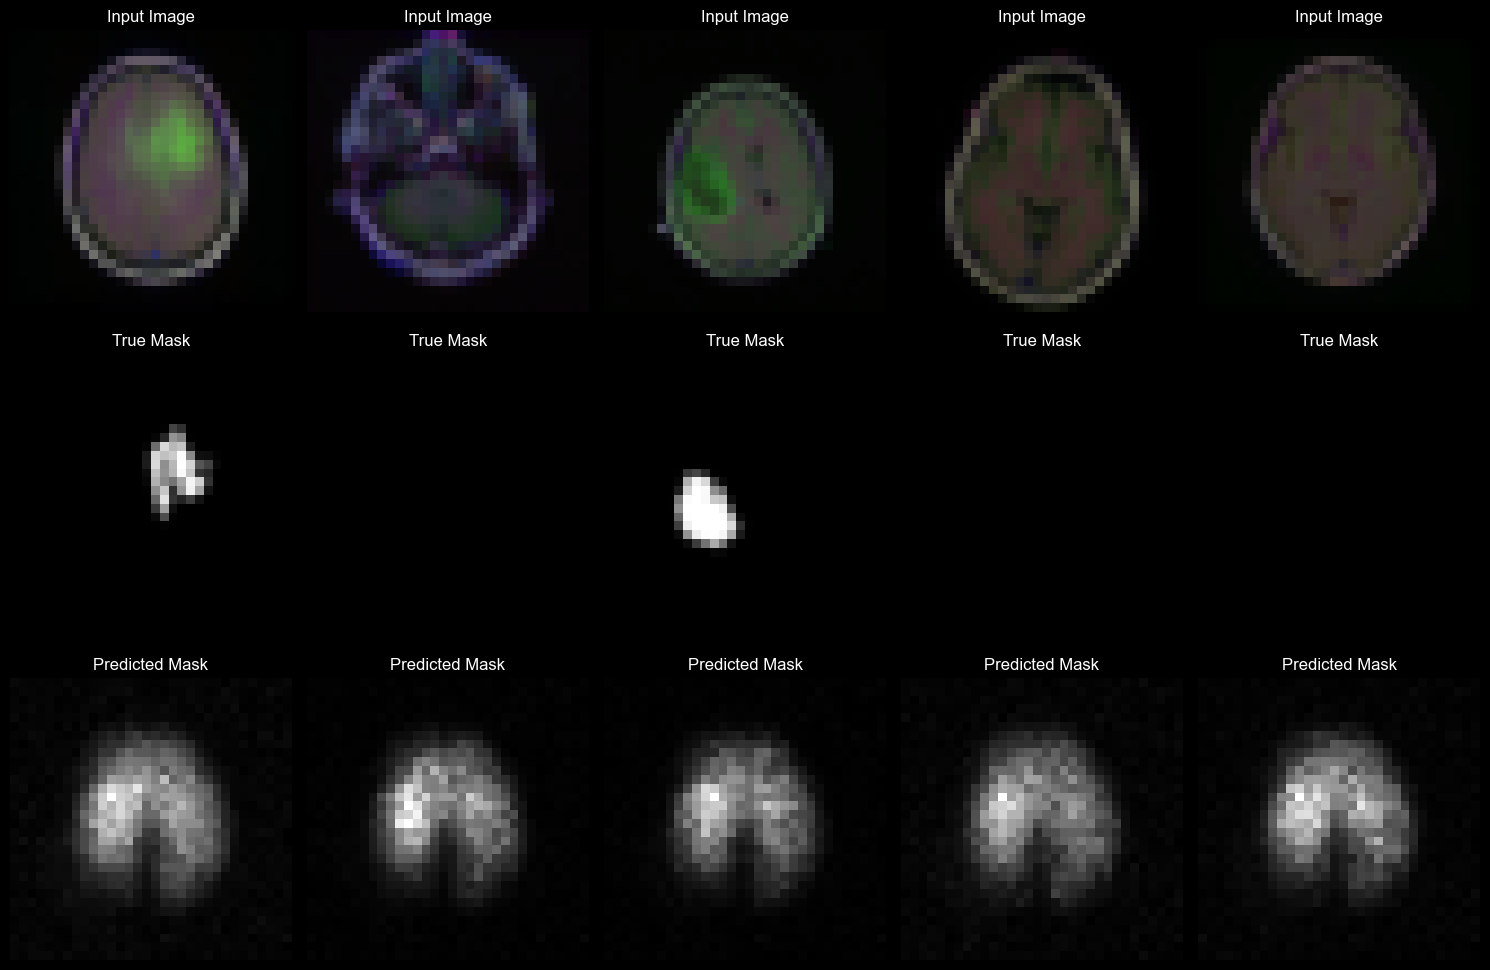

In [24]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, true_masks = next(iter(loader))
    images = images.to(device)
    true_masks = true_masks.to(device)
    with torch.no_grad():
        # Get model predictions and reshape to the mask dimensions
        pred = model.model(images, None)
    # Reshape predictions to match the true mask shape
    pred = pred.reshape(true_masks.size()).cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    images = images.cpu().numpy()
    
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))
    for i in range(num_images):
         # Show input image
         axes[0, i].imshow(images[i].transpose(1, 2, 0))
         axes[0, i].set_title("Input Image")
         axes[0, i].axis("off")
         # Show true mask (using grayscale for clarity)
         axes[1, i].imshow(true_masks[i].transpose(1, 2, 0), cmap='gray')
         axes[1, i].set_title("True Mask")
         axes[1, i].axis("off")
         # Show predicted mask (using grayscale for clarity)
         axes[2, i].imshow(pred[i].transpose(1, 2, 0), cmap='gray')
         axes[2, i].set_title("Predicted Mask")
         axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()


visualize_predictions(vae, test_loader)